In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 
import time
import random
import os
import json
import scipy.spatial.distance
from models.rnnpb import RNNPB
from models.rnnpbnmt import RNNPBNMT
from misc.dataset import Dataset
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D

/home/daniel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
checkp = "ckpt24.51-10"
binding = "0.1"
working_dir = "saves/bindingstrength/rnnpb50000-" + binding

In [4]:
data = Dataset("data/autoenc/easy50000/train.en", "data/autoenc/easy50000/train.en", 1, 
               vocab = os.path.join(working_dir, "vocab"), shuffle=False)

Can't load vocab. File doesn't exist.


NameError: name 'exit' is not defined

In [ ]:
with open(os.path.join(working_dir, "model.json"), "r") as f:
    model_json = json.loads(f.read())

model_name = model_json["model_name"]
model_params = model_json["model_params"]

model = RNNPBNMT(vocab1_size = data.first.vocab_size, vocab2_size = data.second.vocab_size, working_dir=working_dir, **model_params)

In [ ]:
checkpoint_path = os.path.join(working_dir, "checkpoints")
ckpts = os.listdir(checkpoint_path)
#ckpts.remove('checkpoint')
#ckpts = {x for x in ckpts if 'index' not in x}
#ckpts = {x.split('.data', 1)[0] for x in ckpts}
#ckpt_best = min(ckpts, key = lambda x : float(x.lstrip('ckpt').split('-')[0]))
#ckpt_newest = max(ckpts, key = lambda x : int(x.split('-')[-1]))


In [ ]:
checkpoint = model.get_checkp()
checkpoint = tf.train.Checkpoint(**checkpoint)

#assert ckpt_newest is not None
#assert ckpt_best is not None

#ckpt = os.path.join(working_dir, "checkpoints", checkp)
ckpt = tf.train.latest_checkpoint(checkpoint_path)
assert ckpt is not None

print("Restored {} from possible {}".format(ckpt, ckpts))
checkpoint.restore(ckpt)

In [ ]:
def sentence_to_tensor(s, w2idx):
    s = [w2idx.get(w, w2idx["<UNK>"]) for w in s.split(" ")]
    x = tf.convert_to_tensor(s)
    return x

def tensor_to_sentence(x, idx2w):
    return " ".join(idx2w[i] for i in x)

def translate(A, B, x, B_idx2w, eps=0.0001, return_pb = False):
    x = tf.expand_dims(x, 0)
    
    pb = A.recognize(x, eps = eps)[0]
    y = B.generate(pb, max_length = round(1.5 * len(x[0])), start=START, end=END)
    
    s = tensor_to_sentence(y, B_idx2w)
    return (s, pb[0]) if return_pb else s


In [6]:
colors = ['red', 'blue', 'green', 'black', 'orange', 'purple', 'pink', 'gray' ,'cyan', 'magenta']
def plot_pbs(A_pbs, B_pbs, plot_zero = False):

    pb_dim = A_pbs.shape[1]

    pca = PCA(n_components = 2)
    pca.fit(np.concatenate([A_pbs, B_pbs]))

    A_pbs, B_pbs = pca.transform(A_pbs), pca.transform(B_pbs)

    for i in range(A_pbs.shape[0]):

        color = colors[i]

        for p, m in zip([A_pbs[i], B_pbs[i]], ['o', 's']):
            x, y = p

            plt.scatter(x, y, c = color, marker=m)

        legend_elements = [Line2D([0], [0], marker='o', color='w', label='A', markerfacecolor='white', markeredgecolor='black', markersize=7),
                           Line2D([0], [0], marker='s', color='w', label='B', markerfacecolor='white', markeredgecolor='black', markersize=7)]
        plt.legend(handles=legend_elements)

    if plot_zero:
        z = pca.transform(np.zeros((1, pb_dim)))
        x, y = z[0]
        plt.scatter(x, y, c='black', marker='+')
    
    plt.xlabel("First component")
    plt.ylabel("Second component")
    plt.savefig("autotrans_binding_{}.png".format(binding), dpi=1000, bbox_inches = 'tight', pad_inches = 0.1)
    plt.show()

In [ ]:
examples = [row for _, row in zip(range(10), data)]

A_pbs = []
B_pbs = []
for X, X_length, Y, Y_length, ids in examples:
    _, _, A_pb = model.A(X, ids)
    A_pbs.append(A_pb[0])

    _, _, B_pb = model.B(X, ids)
    B_pbs.append(B_pb[0])

In [ ]:
A = np.array(A_pbs)
B = np.array(B_pbs)

In [ ]:
fig = plt.figure(num=1, figsize=(5, 5), frameon=False)
plot_pbs(A, B, plot_zero=True)

In [ ]:
all_A_pbs = model.A.pb_embedding.get_weights()[0]
all_B_pbs = model.B.pb_embedding.get_weights()[0]

In [ ]:
model.A.print_pb_stats()

In [ ]:
model.B.print_pb_stats()

In [ ]:
trained = np.where(np.logical_not(np.all(all_A_pbs == 0, axis = 1)))[0]

all_A_pbs = all_A_pbs[trained]
all_B_pbs = all_B_pbs[trained]

In [ ]:
def calculate_dists(A, B):
    
    dists = []
    for i in range(A.shape[0]):
        dists.append(np.sqrt(np.sum((A - B[i]) ** 2, axis=1)))
        if i % 100 == 0:
            print("Iteration {}/{}".format(i+1, A.shape[0]))
    
    return np.mean(dists)
            

In [ ]:
some_A = all_A_pbs[np.random.randint(0, all_A_pbs.shape[0], 10000)]
some_B = all_B_pbs[np.random.randint(0, all_B_pbs.shape[0], 10000)]

In [ ]:
pair_dist = np.mean(np.sqrt(np.sum((all_A_pbs - all_B_pbs) ** 2, axis=1)))
mean_dist = np.mean(scipy.spatial.distance.cdist(some_A, some_B))

In [ ]:
print(pair_dist, mean_dist)

W0716 14:17:09.444339 139831039362880 legend.py:1384] No handles with labels found to put in legend.


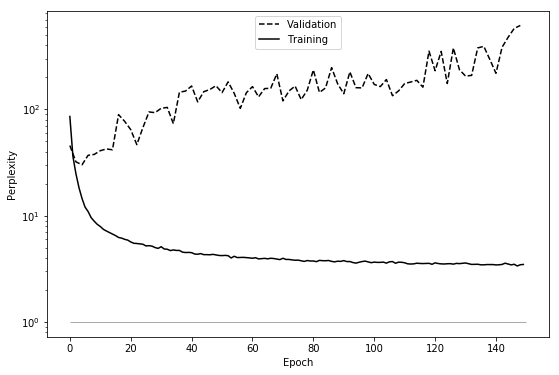

In [14]:
fig = plt.figure(num=2, figsize=(9, 6))
ax = fig.add_subplot(111)
pref = "saves/monoeasy/rnnpb50000-150epochs"

rnnpbs = [""]
for i, model in enumerate(rnnpbs):
    model = pref + model
    with open(os.path.join(model, "training_stats.json"), 'r') as f:
        stats = json.loads(f.read())

    dev_perps = stats['dev_perplexities']
    training_perps = stats['epoch_perplexities']
    
    ax.semilogy(list(range(0, len(dev_perps)*2, 2)), dev_perps, color = "black", linestyle='dashed')
    ax.semilogy(training_perps, color = "black", label=rnnpbs[i])
    
ax.hlines(1, 0, 150, linewidth=1, color='darkgray')

leg1 = ax.legend()

leg2 = [Line2D([0], [0], label='Validation', markersize=7, linestyle='dashed', color='black'),
        Line2D([0], [0], label='Training', markersize=7, color='black')]

ax.legend(handles=leg2, loc='upper center')

#ax.add_artist(leg1)

plt.xlabel("Epoch")
plt.ylabel("Perplexity")

plt.savefig("losses.png", dpi=1000, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()